# 3D (x-y-t) field inference: alpha sensitivity

We start from a flow field generated with `drifter_3D.ipynb` and modify rescale the flow amplitude to change the value of the $\alpha=U\lambda_t/\lambda_s$

In [1]:
import os
from tqdm import tqdm
#import pickle

import numpy as np
import pandas as pd
import xarray as xr
import dask

import matplotlib.pyplot as plt
%matplotlib inline

import corner
import arviz as az

import nwatools.stats as st
colors = st.colors
day = 86400

#data_dir = "data/"
#data_dir = "/home1/scratch/aponte/"
data_dir = "/home/datawork-lops-osi/aponte/nwa/drifter_stats"

/home1/datawork/aponte/miniconda3/envs/equinox/lib/python3.10/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.scheduler.transition-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(
/home1/datawork/aponte/miniconda3/envs/equinox/lib/python3.10/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.comm.recent-messages-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(


ERROR 1: PROJ: proj_create_from_database: Open of /home1/datawork/aponte/miniconda3/envs/equinox/share/proj failed


In [2]:
# actually run production inferences
#prod=True
prod=False

local_cluster = not prod
#local_cluster = True # dev
if local_cluster:
    from dask.distributed import Client, LocalCluster
    cluster = LocalCluster()
else:
    from dask.distributed import Client, LocalCluster
    from dask_jobqueue import PBSCluster
    #cluster = PBSCluster(cores=7*2, processes=7*2, walltime="03:00:00")
    cluster = PBSCluster(processes=10, cores=10, walltime="12:00:00")
    # cores=7, processes=7, 02:00:00 by default
    w = cluster.scale(jobs=10)

client = Client(cluster)
client

/home1/datawork/aponte/miniconda3/envs/equinox/lib/python3.10/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.scheduler.transition-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(
/home1/datawork/aponte/miniconda3/envs/equinox/lib/python3.10/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.comm.recent-messages-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(
/home1/datawork/aponte/miniconda3/envs/equinox/lib/python3.10/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.scheduler.transition-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(
/home1/datawork/aponte/miniconda3/envs/equinox/lib/python3.10/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.comm.recent-message

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 56,Total memory: 100.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:42360,Workers: 8
Dashboard: http://127.0.0.1:8787/status,Total threads: 56
Started: Just now,Total memory: 100.00 GiB
Comm: tcp://127.0.0.1:59634,Total threads: 7
Dashboard: http://127.0.0.1:35677/status,Memory: 12.50 GiB
Nanny: tcp://127.0.0.1:32965,


## Prepare distribution of computations

Computations to be distributed:

- Fixed station inference
- Lagrangian simulation and inference


In [3]:
# flow case
U = "0.1"
#case = "3D_matern32_iso_matern12_pp_r0.0_u"+U
case = "3D_matern52_iso_matern12_pp_r0.0_u"+U
run_dir = os.path.join(data_dir, case)

uv = True # True if u and v are observed
parameter_eta_formulation = False # eta vs nu formulation
noise = 0.01 # observation noise added to u/v
no_time = False # activates time inference
no_space = False
traj_decorrelation = False  # artificially decorrelate different moorings/drifters

# number of points used for inference#

# case 1
Nxy, Nt = 1, 50

# case 2
#no_space = True # ! required to be run if time only reference are necessary !

# case 3
#Nxy, Nt = 4, 50
#traj_decorrelation = True  # artificially decorrelate different moorings/drifters

if no_space:
    # makes little sense otherwise
    parameter_eta_formulation = True
    traj_decorrelation = True
assert not no_time, "need to implement decorrelation across time"


# number of ensembles
#Ne = 5 # dev
Ne = 100 # prod

dx = None
#dx = 100. # Nxy>1, separation between platforms

burn = 500 # number of samples to drop (burning)

### prepare inference

😍AMANDINE👍COLIN🤸🤞🏻

In [4]:
dsf, covfunc, covparams, labels = st.prepare_inference(
    run_dir,
    uv, no_time, no_space,
    parameter_eta_formulation, traj_decorrelation,
)
flow_attrs = dict(**dsf.attrs)
truth = {k: v for k, v in zip(labels, [noise]+covparams)}

# flow scales input
#flow_scales = [.5, 1., 2., 3.]
#flow_scales = np.arange(.1, 5., .2)
# np.logspace(-2,np.log10(2), 10)
alpha = np.array([0.01, .05]+list(np.arange(.1, 2., .1)))
flow_scales = alpha*flow_attrs["lambda_x"]*1e3/flow_attrs["U"]/flow_attrs["lambda_t"]/day
print(f"flow_scales = {flow_scales}")
print(f"alpha = {alpha}")

U 0.1
amplitude0 7.745966692414835
amplitude1 0.0
cov_t matern12
cov_x matern52_iso
cov_y matern52_iso
eta 7.745966692414835
kind pp
lambda_t 5
lambda_x 100
lambda_y 100
nu_space 2.5
nu_time 0.5
noise 0.0
pp_ratio 0.0
dx 2.0
dy 2.0
flow_scales = [0.02314815 0.11574074 0.23148148 0.46296296 0.69444444 0.92592593
 1.15740741 1.38888889 1.62037037 1.85185185 2.08333333 2.31481481
 2.5462963  2.77777778 3.00925926 3.24074074 3.47222222 3.7037037
 3.93518519 4.16666667 4.39814815]
alpha = [0.01 0.05 0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1.   1.1  1.2
 1.3  1.4  1.5  1.6  1.7  1.8  1.9 ]


---

## run/load inferences

### mooring inference

In [5]:
def get_file_path_mooring(flow_scale, Nxy, dx, no_space, traj_decorrelation):
    nc = os.path.join(run_dir, f"moorings_fs{flow_scale:.4f}_Nxy{Nxy}.nc")
    if dx is not None:
        nc = nc.replace(".nc", f"_dx{dx:0.0f}.nc")
    if no_space:
        nc = nc.replace(".nc", f"_nospace.nc")
    if traj_decorrelation:
        nc = nc.replace(".nc", f"_trajd.nc")
    return nc
    
def run_inferences_mooring(flow_scale):

    nc = get_file_path_mooring(flow_scale, Nxy, dx, no_space, traj_decorrelation)

    # note: does not overwrite
    if prod and not os.path.isfile(nc):
        ds = st.run_mooring_ensembles(
            Ne, dsf, 
            covparams, covfunc, labels, (Nt, Nxy), 
            noise, dx=dx,
            flow_scale=flow_scale,
        ) 
        ds.to_netcdf(nc, mode="w")
    else:
        ds = xr.open_dataset(nc)
        ds["parameter"] = ds.parameter.astype(str)
        
    return ds

def load_inferences_mooring(no_space):

    Dm = []
    for flow_scale in flow_scales:
        trajd = traj_decorrelation
        if no_space:
            trajd = True
        nc = get_file_path_mooring(flow_scale, Nxy, dx, no_space, trajd)
        ds = xr.open_dataset(nc)
        ds["parameter"] = ds.parameter.astype(str)
        # move noise last
        if no_space:
            ds = ds.sel(parameter=['u', 'λt', 'σ'])
        else:
            ds = ds.sel(parameter=['γ', 'λx', 'λt', 'σ'])
        Dm.append(ds)
        
    return Dm

In [6]:
Dm = []
for f in tqdm(flow_scales):
    Dm.append(run_inferences_mooring(f))

100%|██████████| 21/21 [00:02<00:00,  7.13it/s]



### drifter inference

- Lagrangian simulation
- actual inference


In [7]:
## setup parcels

def run_lagrangian_simulation(flow_scale, overwrite=False):

    import xarray as xr
    from datetime import timedelta
    from parcels import (
        AdvectionRK4,
        FieldSet,
        JITParticle,
        ParticleSet,
        Variable,
    )
        
    # output file
    zarr_file = os.path.join(run_dir, f"drifters_fs{flow_scale:.2f}.zarr")
    if os.path.isdir(zarr_file) and not overwrite:
        return

    #with dask.config.set(scheduler="threads"):    
    # assemble Field set
    flow_file = os.path.join(run_dir, "flow.zarr")
    ds = xr.open_zarr(flow_file, decode_times=False)
    ds["u"] = ds["u"]*flow_scale
    ds["v"] = ds["v"]*flow_scale
    ds["x"] = ds["x"]*1e3 # rescale in m
    ds["y"] = ds["y"]*1e3 # rescale in m
    dx = float(ds["x"][1]-ds["x"][0])
    dy = float(ds["y"][1]-ds["y"][0])
    ds = ds.rename(x="lon", y="lat")
    ds["time"] = ds["time"]*day # rescale in seconds
    ds["time"].attrs.update(units="seconds")

    # define bounds to kill trajectories
    nb = 2
    bounds = (float(ds["lon"].values[0])  + nb*dx,
              float(ds["lon"].values[-1]) - nb*dx,
              float(ds["lat"].values[0])  + nb*dy,
              float(ds["lat"].values[-1]) - nb*dy,
    )

    # generate fieldset
    fieldset = FieldSet.from_xarray_dataset(
        ds,
        variables=dict(U="u", V="v"),
        dimensions=dict(lon="lon", lat="lat", time="time"),                         
        mesh="flat",
    )

    # create Particle set
    di = 5 # subsampling step of input flow grid for parcel seeding position
    _ds = ds.isel(lon=slice(10, -10, di), lat=slice(10, -10, di))    
    #_ds = ds.isel(lon=slice(10,-10,1), lat=slice(10,-10,1)) # coarse grid
    #_ds = ds.isel(lon=slice(10,-10,10), lat=slice(10,-10,10))
    x0 = (_ds.lon   + _ds.lat*0).values.flatten()
    y0 = (_ds.lon*0 + _ds.lat  ).values.flatten()

    pset = ParticleSet.from_list(
        fieldset=fieldset,  # the fields on which the particles are advected
        pclass=JITParticle,  # the type of particles (JITParticle or ScipyParticle)
        lon=x0,  # a vector of release longitudes
        lat=y0,  # a vector of release latitudes
        #time=t0,
    )

    output_file = pset.ParticleFile(
        name=zarr_file,  # the file name
        outputdt=timedelta(hours=1),  # the time step of the outputs
    )

    Tmax = np.floor(float(max(ds["time"]/day)))

    # deal with boundaries
    fieldset.add_constant('b0', bounds[0])
    fieldset.add_constant('b1', bounds[1])
    fieldset.add_constant('b2', bounds[2])
    fieldset.add_constant('b3', bounds[3])
    def StopParticle(particle, fieldset, time):
        # https://github.com/OceanParcels/parcels/blob/bf98c977a260afd86e91ce7af8f3af7dfef90edf/docs/examples/example_stommel.py#L86
        # https://docs.oceanparcels.org/en/latest/reference/particles.html#module-parcels.particle
        #if (particle.lon < bounds[0]) or (particle.lon > bounds[1]) or (particle.lat < bounds[2]) or (particle.lat > bounds[2]):
        if (particle.lon < fieldset.b0) or (particle.lon > fieldset.b1) \
            or (particle.lat < fieldset.b2) or (particle.lat > fieldset.b3):
            particle.delete()
            
    pset.execute(
        AdvectionRK4+pset.Kernel(StopParticle),  # the kernel (which defines how particles move)
        #AdvectionRK4,  # the kernel (which defines how particles move)
        runtime=timedelta(days=Tmax),  # the total length of the run
        dt=timedelta(minutes=30),  # the timestep of the kernel
        #dt=timedelta(minutes=30),  # the timestep of the kernel
        output_file=output_file,
        verbose_progress=False,
    )

    # necessary for older version of parcels (as old as 2.3.0 at least)
    #output_file.export()

#### drifter advection

In [8]:
#Can't distribute parcels simulation for some reason
if prod:
    for f in flow_scales:
        print(f" start {f}")
        run_lagrangian_simulation(f, overwrite=False)
        print(f" end {f}")

#cluster.close()

#### inference

In [9]:
def get_file_path_drifter(flow_scale, Nxy, dx, no_space, traj_decorrelation):
    nc = os.path.join(run_dir, f"drifters_fs{flow_scale:.2f}_Nxy{Nxy}.nc")
    #nc = os.path.join(run_dir, f"drifters_fs{flow_scale:.4f}_Nxy{Nxy}.nc")
    if dx is not None:
        nc = nc.replace(".nc", f"_dx{dx:0.0f}.nc")
    if no_space:
        nc = nc.replace(".nc", f"_nospace.nc")
    if traj_decorrelation:
        nc = nc.replace(".nc", f"_trajd.nc")
    return nc

def run_inferences_drifter(flow_scale):

    nc = get_file_path_drifter(flow_scale, Nxy, dx, no_space, traj_decorrelation)

    # note: does not overwrite
    if prod and not os.path.isfile(nc):
        ds = st.run_drifter_ensembles(
            run_dir,
            Ne,
            covparams, covfunc, labels, (Nt, Nxy), noise, 
            dx=dx, 
            flow_scale=flow_scale,
        ) 
        ds.to_netcdf(nc, mode="w")
    else:
        ds = xr.open_dataset(nc)
        ds["parameter"] = ds.parameter.astype(str)
        
    return ds

def load_inferences_drifter(no_space):

    Dr = []
    for flow_scale in flow_scales:
        trajd = traj_decorrelation
        if no_space:
            trajd = True
        nc = get_file_path_drifter(flow_scale, Nxy, dx, no_space, trajd)
        ds = xr.open_dataset(nc)
        ds["parameter"] = ds.parameter.astype(str)
        if no_space:
            ds = ds.sel(parameter=['u', 'λt', 'σ'])
        else:
            ds = ds.sel(parameter=['γ', 'λx', 'λt', 'σ'])
        Dr.append(ds)
    
    return Dr

In [10]:
Dr = []
for f in tqdm(flow_scales):
    Dr.append(run_inferences_drifter(f))

100%|██████████| 21/21 [00:02<00:00,  9.66it/s]


---
## concatenate and inspect

In [11]:
if "velocity_deficit" not in flow_attrs:
    flow_attrs["velocity_deficit"] = st.amplitude_decifit(
        flow_attrs["dx"], flow_attrs["lambda_x"], flow_attrs["nu_space"],
    )
    _f = flow_attrs["velocity_deficit"]
    print(f"add velocity_deficit: {_f:.02f}")

add velocity_deficit: 1.00


In [12]:
def _pprocess(ds, λx=None):
    ds = ds.copy()
    for v in ["true_parameters", "flow_scale", "survival_rate", "lower", "upper"]:
        if v in ds:
            ds[v] = ds[v].isel(ensemble=0)
    ds["U"] = float(U) * ds.flow_scale * flow_attrs["velocity_deficit"]
    λt = float(ds["true_parameters"].sel(parameter="λt"))
    if λx is None:
        λx = float(ds["true_parameters"].sel(parameter="λx"))
    ds = (ds
      .assign_coords(α = ds["U"] * λt*day/(λx*1e3))
      .set_coords("true_parameters")
    )
    ds.attrs.update(**flow_attrs)
    if "λx" in ds.parameter.values:
        ds = ds.sel(parameter=['γ', 'λx', 'λt', 'σ'])    
    else:
        ds = ds.sel(parameter=['u', 'λt', 'σ'])
    return ds

dsm = xr.concat([_pprocess(d) for d in Dm], "flow_scale")
dsr = xr.concat([_pprocess(d) for d in Dr], "flow_scale")

In [13]:
# purely temporal inference
Dm_nospace = load_inferences_mooring(True)
Dr_nospace = load_inferences_drifter(True)

dsm_nospace = xr.concat([_pprocess(d, λx=flow_attrs["lambda_x"]) for d in Dm_nospace], "flow_scale")
dsr_nospace = xr.concat([_pprocess(d, λx=flow_attrs["lambda_x"]) for d in Dr_nospace], "flow_scale")

In [14]:
bounds = dict(
    σ=(-.01,.1),
    γ=(-.01,.35),
    λx=(-50,1100),
    λt=(-1,20),
)
# common kwargs
kw = dict(x="α", x_off=.055, x_width=0.04, bounds=bounds)

In [15]:
def add_nospace(ds, c, axes, alpha_normalize=False):
    
    for p, k in zip(dsm.parameter.values, axes):
        ax = axes[k]
        if p=="γ":
            da = ds["MAP"].sel(parameter="u").median("ensemble")
            da = np.sqrt( (flow_attrs["nu_space"]-1)/flow_attrs["nu_space"] ) * da
            if alpha_normalize:
                da = (da/da["α"]).rename("γ/α")
            # need to recompose gamma = eta / lambdax = np.sqrt((ν-1)/ν) * U
            ax.plot(da["α"], da, color=c, ls="--")
        if p=="λt":
            da = ds["MAP"].sel(parameter=p) #.median("ensemble")
            #ax.plot(da["α"], da, color=c, ls="--")
            st._shadeplot(ax, da, da["α"], alpha=0.3, color=c)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


scp dunree:/home1/datawork/aponte/code/nwa/stats/figs/matern52_iso_alpha_MAP.eps .
scp dunree:/home1/datawork/aponte/code/nwa/stats/figs/matern52_iso_alpha_MAP.png .


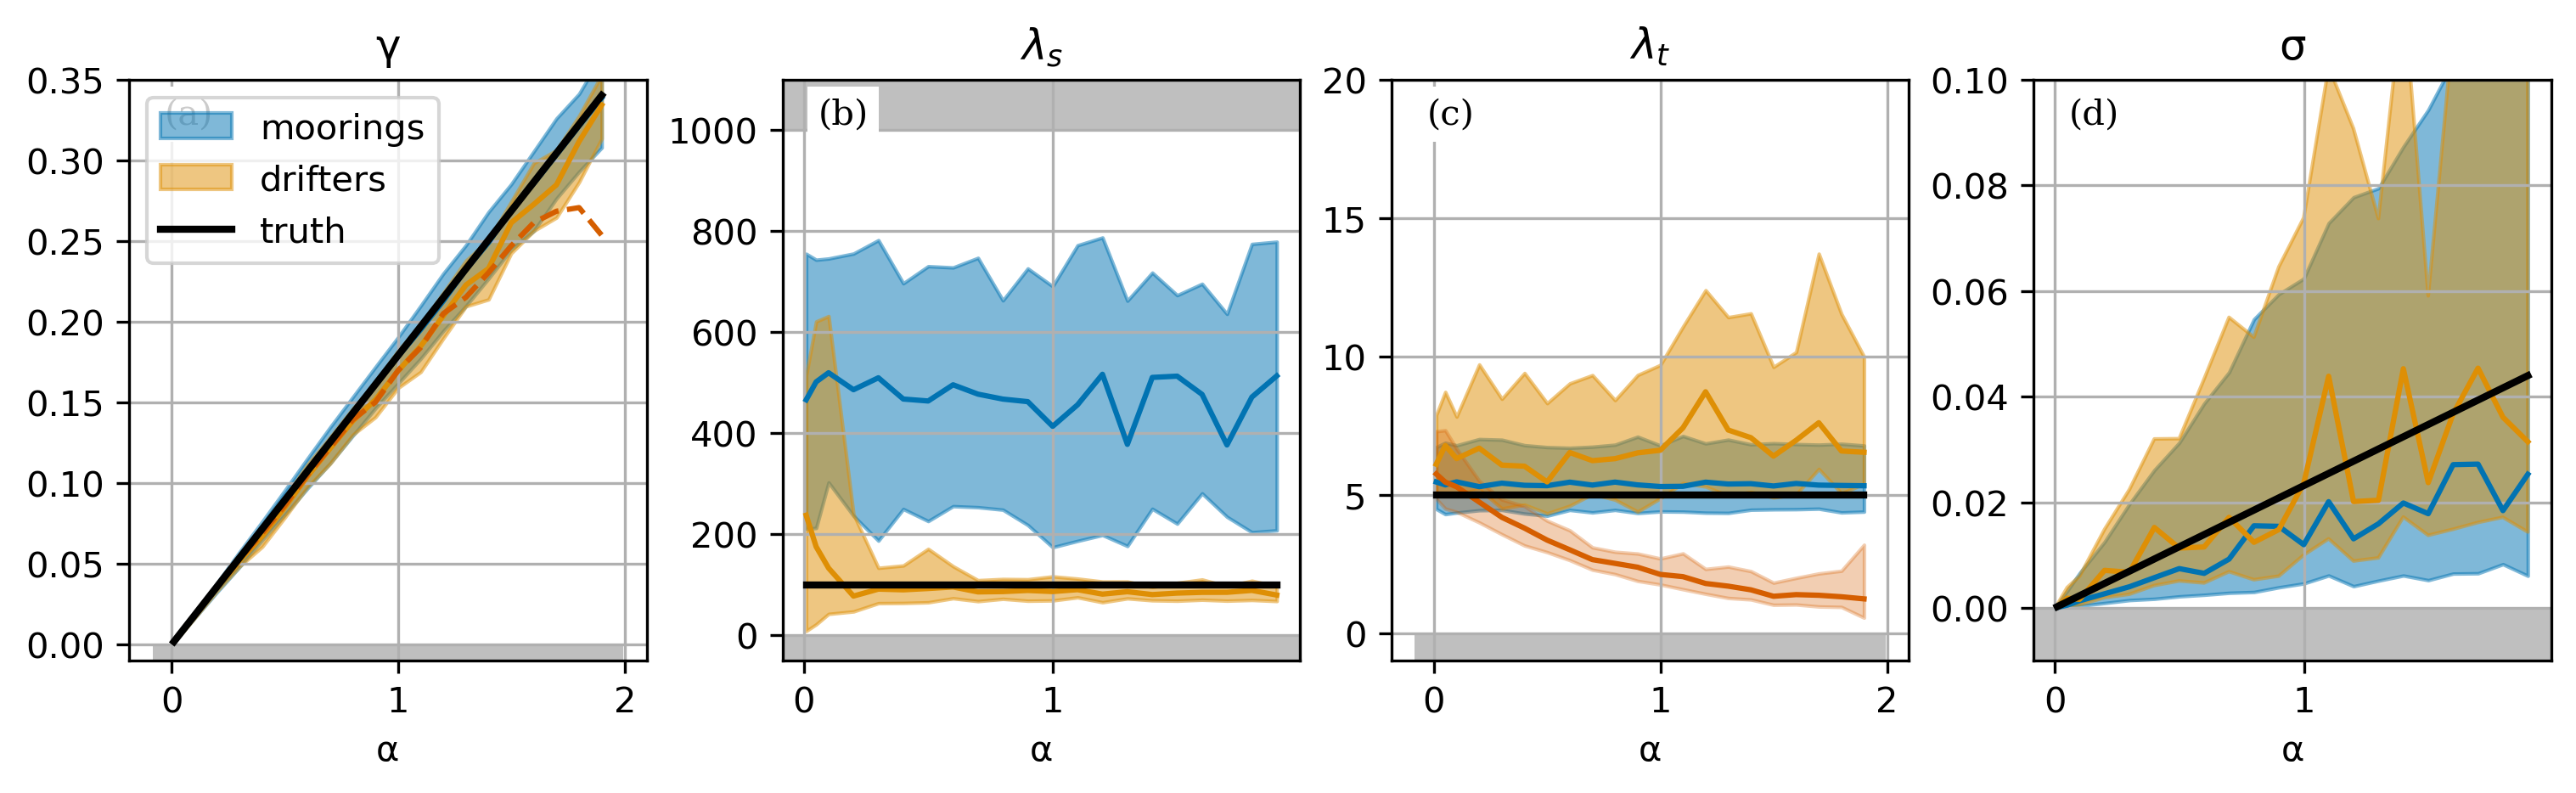

In [17]:
fig, axes = st.plot_sensitivity_combined(
    dsm, dsr, alpha=0.5, legend_loc=0, alpha_normalize=False, **kw,
)

#add_nospace(dsr_nospace, colors["dr"], axes)
#add_nospace(dsm_nospace, colors["mo"], axes)
add_nospace(dsr_nospace, st.cpal[3], axes)

st.label_and_print(fig, axes, flow_attrs["cov_x"]+"_alpha_MAP")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


scp dunree:/home1/datawork/aponte/code/nwa/stats/figs/matern52_iso_alpha_MAP_alphanorm.eps .
scp dunree:/home1/datawork/aponte/code/nwa/stats/figs/matern52_iso_alpha_MAP_alphanorm.png .


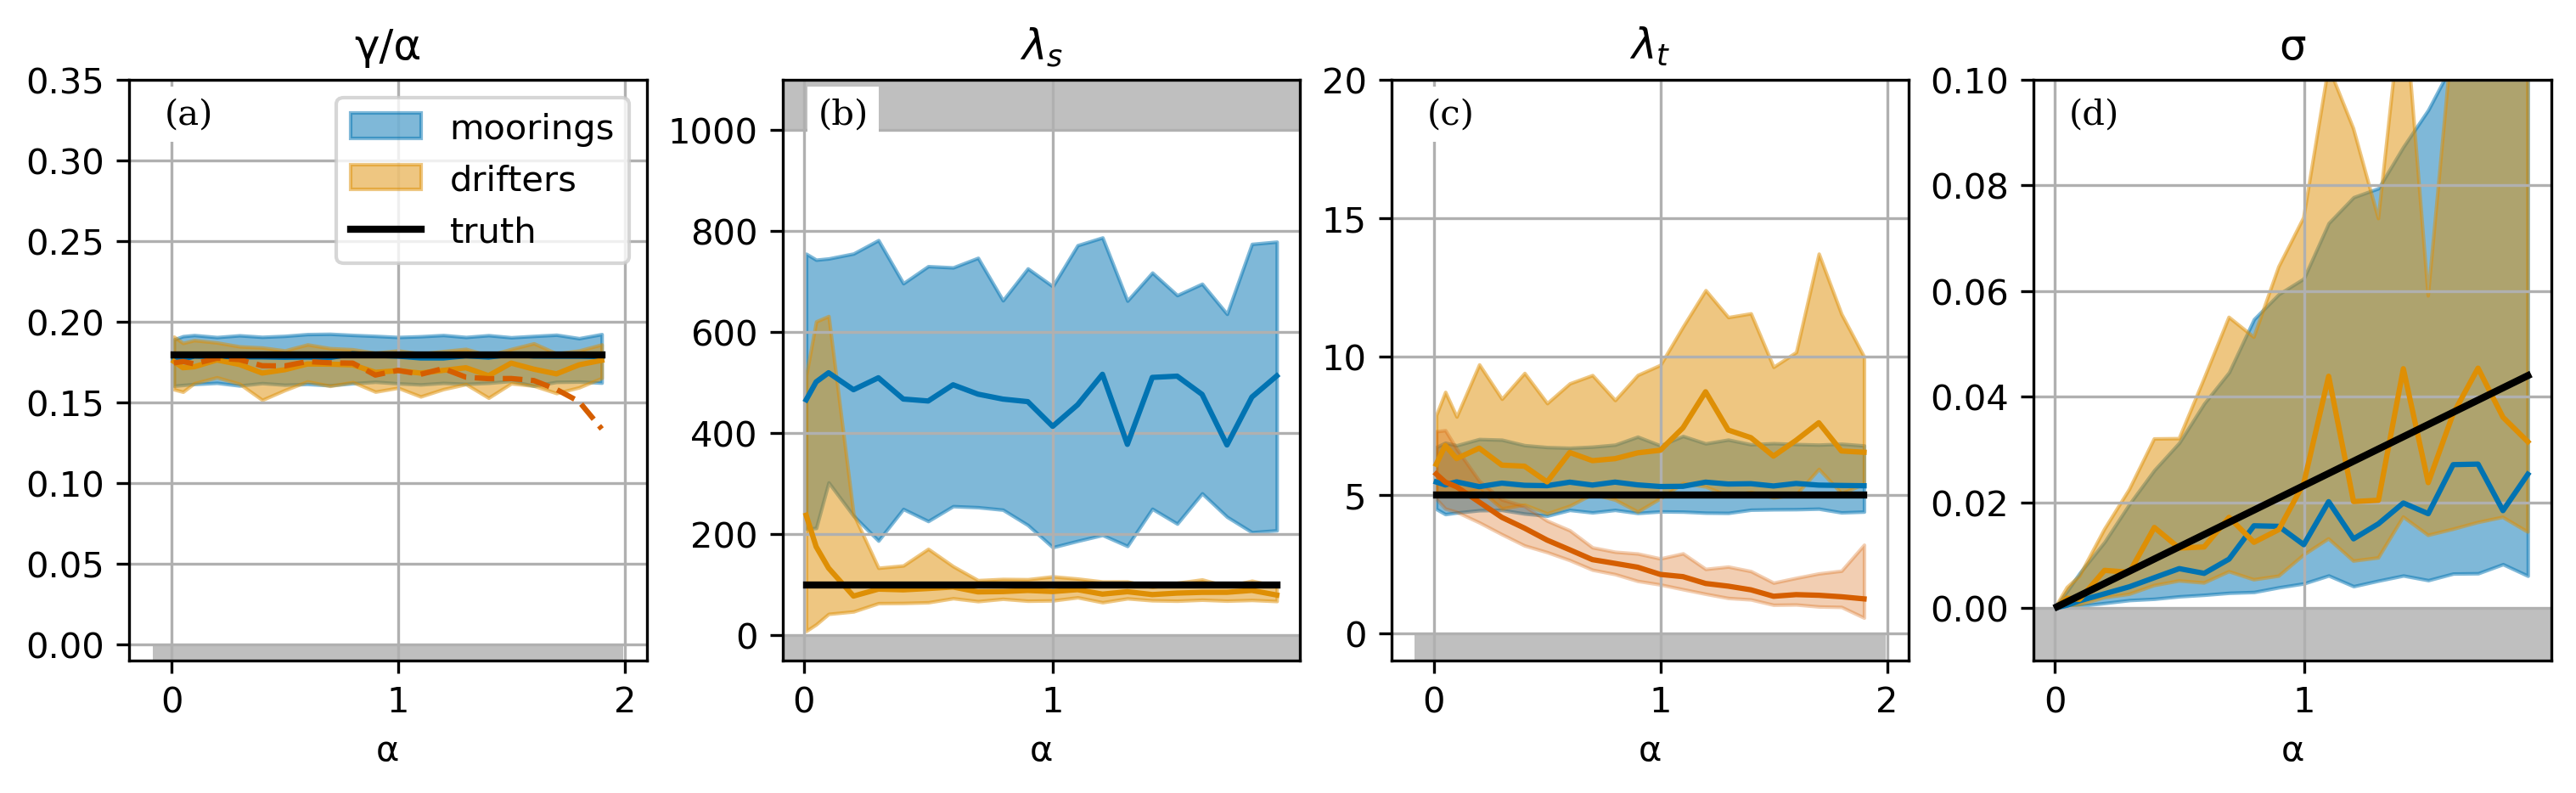

In [18]:
fig, axes = st.plot_sensitivity_combined(
    dsm, dsr, alpha=0.5, legend_loc=0, alpha_normalize=True, **kw,
)

#add_nospace(dsr_nospace, colors["dr"], axes)
#add_nospace(dsm_nospace, colors["mo"], axes)
add_nospace(dsr_nospace, st.cpal[3], axes, alpha_normalize=True)

st.label_and_print(fig, axes, flow_attrs["cov_x"]+"_alpha_MAP_alphanorm")

In [19]:
# print MAP - truth difference along with normalized difference
st.print_MAP_truth_difference(dsr, "flow_scale")

% flow_scale | γ | λx | λt | σ
% 0.023148148148148147 | 0.00 / 0.00 | 238.04 / 100.00 | 6.10 / 5.00 | 0.00 / 0.00
% normalized diff | -2.3 | 58.0 | 18.1 | -4.0
% 0.11574074074074074 | 0.01 / 0.01 | 175.68 / 100.00 | 6.78 / 5.00 | 0.00 / 0.00
% normalized diff | -4.6 | 43.1 | 26.2 | 36.8
% 0.23148148148148148 | 0.02 / 0.02 | 133.30 / 100.00 | 6.31 / 5.00 | 0.00 / 0.00
% normalized diff | -4.2 | 25.0 | 20.7 | -42.2
% 0.46296296296296297 | 0.04 / 0.04 | 77.93 / 100.00 | 6.68 / 5.00 | 0.01 / 0.00
% normalized diff | -1.8 | -28.3 | 25.2 | 34.8
% 0.6944444444444444 | 0.05 / 0.05 | 91.73 / 100.00 | 6.07 / 5.00 | 0.01 / 0.01
% normalized diff | -3.4 | -9.0 | 17.6 | -3.0
% 0.9259259259259259 | 0.07 / 0.07 | 90.28 / 100.00 | 6.03 / 5.00 | 0.02 / 0.01
% normalized diff | -6.7 | -10.8 | 17.1 | 39.2
% 1.1574074074074074 | 0.09 / 0.09 | 92.89 / 100.00 | 5.46 / 5.00 | 0.01 / 0.01
% normalized diff | -5.4 | -7.7 | 8.5 | -2.2
% 1.3888888888888888 | 0.10 / 0.11 | 95.91 / 100.00 | 6.53 / 5.00 | 0.01 / 0.

In [20]:
st.print_MAP_truth_difference(dsr_nospace, "flow_scale")

% flow_scale | u | λt | σ
% 0.023148148148148147 | 0.00 / 0.00 | 5.75 / 5.00 | 0.00 / 0.00
% normalized diff | -2.8 | 13.0 | -235.0
% 0.11574074074074074 | 0.01 / 0.01 | 5.46 / 5.00 | 0.00 / 0.00
% normalized diff | -2.3 | 8.4 | 0.0
% 0.23148148148148148 | 0.02 / 0.02 | 5.29 / 5.00 | 0.00 / 0.00
% normalized diff | -3.2 | 5.4 | -278.5
% 0.46296296296296297 | 0.05 / 0.05 | 4.74 / 5.00 | 0.00 / 0.00
% normalized diff | -1.1 | -5.6 | -231.8
% 0.6944444444444444 | 0.07 / 0.07 | 4.18 / 5.00 | 0.00 / 0.01
% normalized diff | -1.6 | -19.5 | -275.3
% 0.9259259259259259 | 0.09 / 0.09 | 3.79 / 5.00 | 0.00 / 0.01
% normalized diff | -3.9 | -31.8 | -202.6
% 1.1574074074074074 | 0.11 / 0.12 | 3.36 / 5.00 | 0.00 / 0.01
% normalized diff | -3.9 | -48.9 | -229.5
% 1.3888888888888888 | 0.14 / 0.14 | 3.01 / 5.00 | 0.00 / 0.01
% normalized diff | -2.3 | -66.1 | -219.5
% 1.6203703703703705 | 0.16 / 0.16 | 2.65 / 5.00 | 0.01 / 0.02
% normalized diff | -2.8 | -88.4 | -199.8
% 1.8518518518518519 | 0.18 / 0.1

In [20]:
st.print_quantile_width(dsm, "flow_scale")
st.print_quantile_width(dsr, "flow_scale")

% flow_scale | γ | λx | λt | σ
% 0.023148148148148147 | 0.16 | 5.45 | 0.45 | 2.47
% 0.11574074074074074 | 0.17 | 5.31 | 0.52 | 2.59
% 0.23148148148148148 | 0.17 | 4.43 | 0.49 | 2.68
% 0.46296296296296297 | 0.16 | 5.19 | 0.51 | 2.50
% 0.6944444444444444 | 0.17 | 5.95 | 0.51 | 2.62
% 0.9259259259259259 | 0.16 | 4.47 | 0.49 | 2.63
% 1.1574074074074074 | 0.17 | 5.05 | 0.50 | 2.51
% 1.3888888888888888 | 0.17 | 4.73 | 0.45 | 2.61
% 1.6203703703703705 | 0.18 | 4.94 | 0.48 | 2.58
% 1.8518518518518519 | 0.17 | 4.14 | 0.47 | 2.79
% 2.0833333333333335 | 0.16 | 5.08 | 0.55 | 2.67
% 2.314814814814815 | 0.16 | 5.17 | 0.48 | 2.49
% 2.5462962962962963 | 0.17 | 5.85 | 0.55 | 2.62
% 2.7777777777777777 | 0.17 | 5.89 | 0.50 | 2.65
% 3.00925925925926 | 0.16 | 4.86 | 0.53 | 2.47
% 3.240740740740741 | 0.16 | 4.68 | 0.47 | 2.51
% 3.4722222222222228 | 0.15 | 4.52 | 0.48 | 2.57
% 3.7037037037037037 | 0.17 | 4.15 | 0.47 | 2.61
% 3.935185185185186 | 0.16 | 4.02 | 0.46 | 2.66
% 4.166666666666667 | 0.15 | 5.71 | 0.

In [1]:
#fig, axes = st.plot_sensitivity_combined(dsm, dsr, type="boxplot", **kw)

In [ ]:
fig, axes = st.plot_sensitivity_combined(
    dsm, None, label="moorings", alpha=0.5, **kw,
)

In [ ]:
fig, axes = st.plot_sensitivity_combined(
    dsr, None, label="drifters", c=colors["dr"], alpha=0.5, **kw,
)

---
## survival rate

[99.97829861  5.05642361]


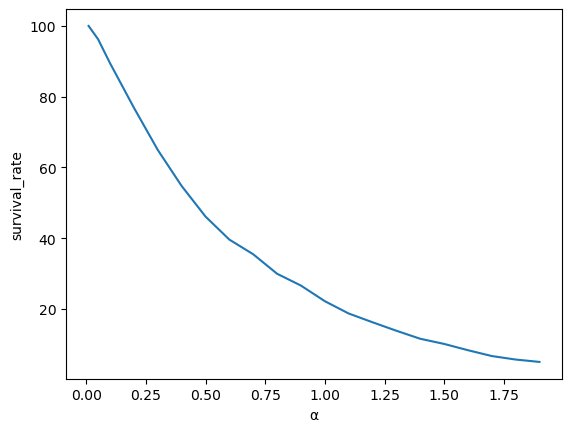

In [19]:
#fig, ax = plt.subplots(1,1)
dsr["survival_rate"].plot(x="α")
#ax.grid()

print(dsr["survival_rate"].isel(flow_scale=[0,-1]).values)

----

In [11]:
cluster.close()